## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 7 slices in the middle
* slide inference

In [1]:
idxs = range(65)
idxs

range(0, 65)

In [2]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [3]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [4]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [6]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [7]:
import segmentation_models_pytorch as smp

In [8]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [9]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp013'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 7 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [12]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [13]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [14]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [15]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    # mid = 65 // 2
    # start = mid - CFG.in_chans // 2
    # end = mid + CFG.in_chans // 2
    # idxs = range(start, end)
    idxs = [0,16,31,32,33,48,64]

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [16]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [17]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [19]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [20]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [21]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [22]:
train_dataset[0][0].shape

torch.Size([7, 224, 224])

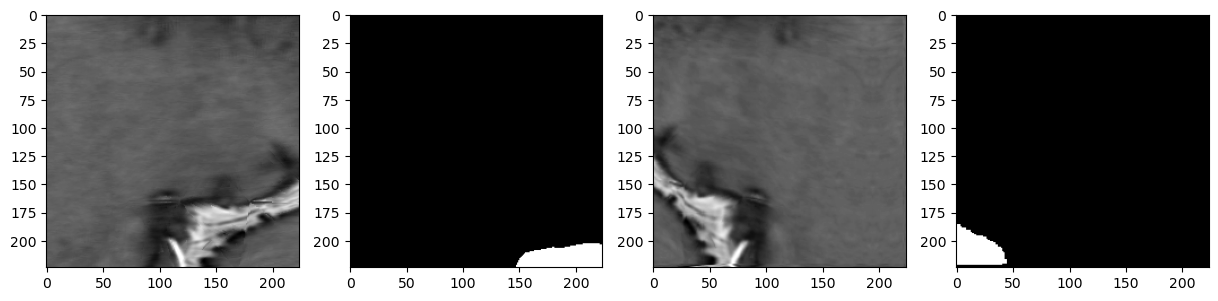

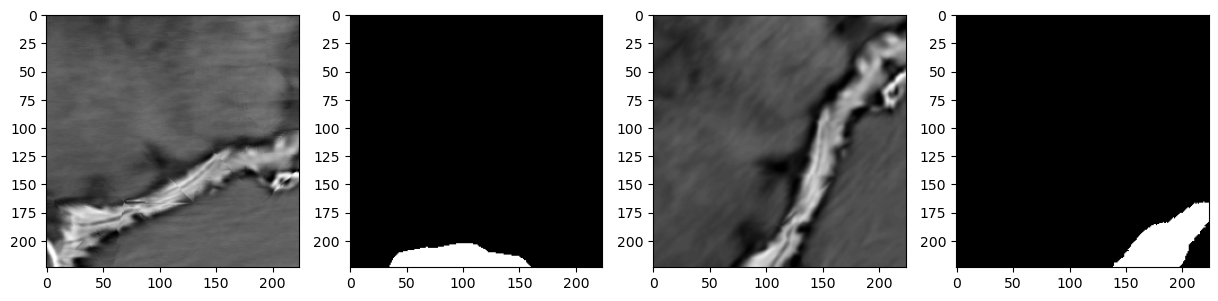

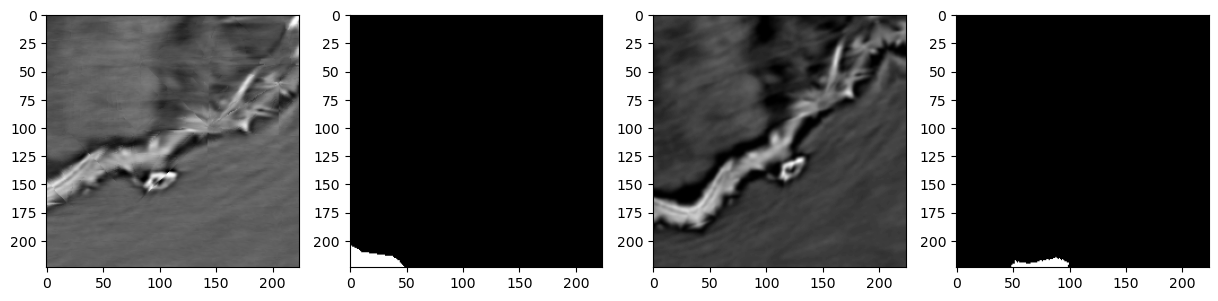

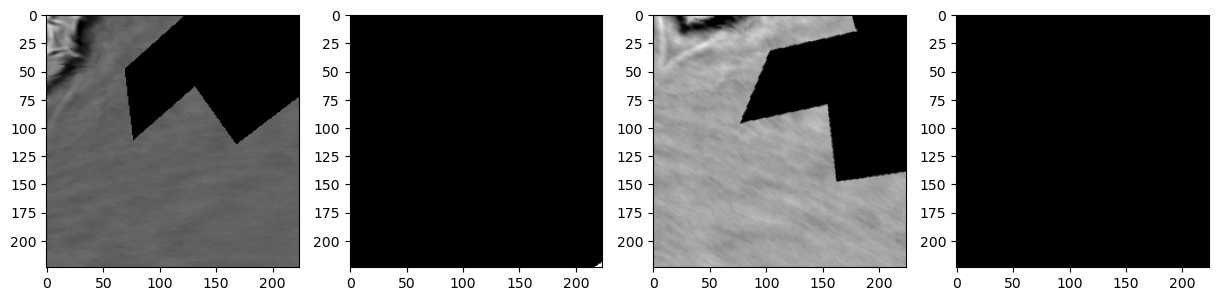

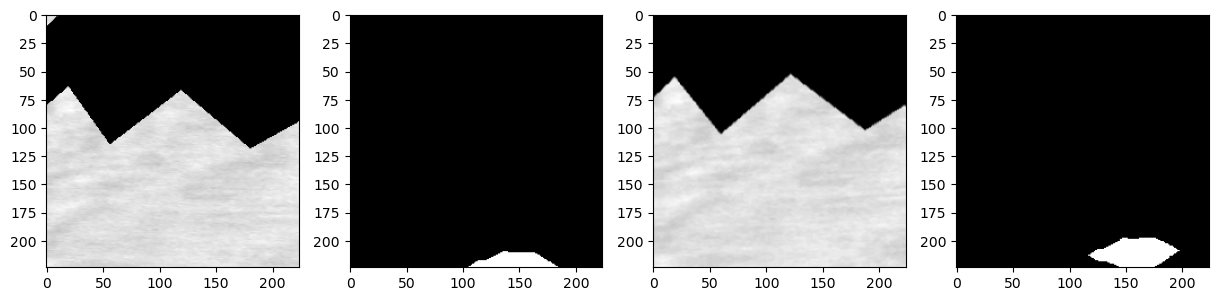

In [23]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [24]:
del plot_dataset
gc.collect()

48115

## model

In [25]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [26]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [27]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [28]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [30]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [31]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [32]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [33]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [34]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.21240088938452803
th: 0.15, fbeta: 0.2284064338001041
th: 0.2, fbeta: 0.2377696927314235
th: 0.25, fbeta: 0.24634599131268467
th: 0.3, fbeta: 0.2602790821479538
th: 0.35, fbeta: 0.2805611318981045
th: 0.4, fbeta: 0.22795377058803457
th: 0.45, fbeta: 0.04158252842132991


best_th: 0.35, fbeta: 0.2805611318981045
Epoch 1 - avg_train_loss: 0.4014  avg_val_loss: 0.3185  time: 230s
Epoch 1 - avgScore: 0.2806
Epoch 1 - Save Best Score: 0.2806 Model
Epoch 1 - Save Best Loss: 0.3185 Model


th: 0.5, fbeta: 0.001677821311911738


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2348309211824628
th: 0.15, fbeta: 0.25511166768511695
th: 0.2, fbeta: 0.27902418046307187
th: 0.25, fbeta: 0.3125526162057241
th: 0.3, fbeta: 0.35477191216508924
th: 0.35, fbeta: 0.34599198498137873
th: 0.4, fbeta: 0.17190659331928862
th: 0.45, fbeta: 0.0019062879803744368


best_th: 0.3, fbeta: 0.35477191216508924
Epoch 2 - avg_train_loss: 0.3158  avg_val_loss: 0.2774  time: 231s
Epoch 2 - avgScore: 0.3548
Epoch 2 - Save Best Score: 0.3548 Model
Epoch 2 - Save Best Loss: 0.2774 Model


th: 0.5, fbeta: 1.2171825165729448e-05


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2398977183266565
th: 0.15, fbeta: 0.25840349470318447
th: 0.2, fbeta: 0.2869506660919794
th: 0.25, fbeta: 0.3032818864284631
th: 0.3, fbeta: 0.31702276126256795
th: 0.35, fbeta: 0.32605650290671545
th: 0.4, fbeta: 0.3298721482308685
th: 0.45, fbeta: 0.31759630628874325


best_th: 0.4, fbeta: 0.3298721482308685
Epoch 3 - avg_train_loss: 0.2803  avg_val_loss: 0.2629  time: 231s
Epoch 3 - avgScore: 0.3299


th: 0.5, fbeta: 0.15860585277943393


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2555151807393964
th: 0.15, fbeta: 0.28232777074730975
th: 0.2, fbeta: 0.3066794750131749
th: 0.25, fbeta: 0.3197051528776452
th: 0.3, fbeta: 0.330503545106047
th: 0.35, fbeta: 0.34314086062897997
th: 0.4, fbeta: 0.3537052666392153
th: 0.45, fbeta: 0.34953945171625034


best_th: 0.4, fbeta: 0.3537052666392153
Epoch 4 - avg_train_loss: 0.2616  avg_val_loss: 0.2575  time: 230s
Epoch 4 - avgScore: 0.3537


th: 0.5, fbeta: 0.31682851334271095


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2787882027601228
th: 0.15, fbeta: 0.30285663671325813
th: 0.2, fbeta: 0.323674250727516
th: 0.25, fbeta: 0.34463810148000273
th: 0.3, fbeta: 0.36906287786916303
th: 0.35, fbeta: 0.389178725511122
th: 0.4, fbeta: 0.4076798618871174
th: 0.45, fbeta: 0.41707775654102575


best_th: 0.45, fbeta: 0.41707775654102575
Epoch 5 - avg_train_loss: 0.2519  avg_val_loss: 0.2497  time: 228s
Epoch 5 - avgScore: 0.4171
Epoch 5 - Save Best Score: 0.4171 Model
Epoch 5 - Save Best Loss: 0.2497 Model


th: 0.5, fbeta: 0.3943453046277359


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36245341186083735
th: 0.15, fbeta: 0.3953725296778377
th: 0.2, fbeta: 0.41461833654640584
th: 0.25, fbeta: 0.4224068938303755
th: 0.3, fbeta: 0.4183044188726711
th: 0.35, fbeta: 0.40823939239204887
th: 0.4, fbeta: 0.3878949794662573
th: 0.45, fbeta: 0.3629619102478217


best_th: 0.25, fbeta: 0.4224068938303755
Epoch 6 - avg_train_loss: 0.2406  avg_val_loss: 0.2842  time: 229s
Epoch 6 - avgScore: 0.4224
Epoch 6 - Save Best Score: 0.4224 Model
Epoch 6 - Save Best Loss: 0.2842 Model


th: 0.5, fbeta: 0.337757135125659


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33644890425372487
th: 0.15, fbeta: 0.3564325245142145
th: 0.2, fbeta: 0.370985822763724
th: 0.25, fbeta: 0.37294175456445683
th: 0.3, fbeta: 0.35854501360527063
th: 0.35, fbeta: 0.3269405292685516
th: 0.4, fbeta: 0.2870685752933326
th: 0.45, fbeta: 0.24034794383162392


best_th: 0.25, fbeta: 0.37294175456445683
Epoch 7 - avg_train_loss: 0.2302  avg_val_loss: 0.3078  time: 228s
Epoch 7 - avgScore: 0.3729


th: 0.5, fbeta: 0.19212647603013008


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2975982958250353
th: 0.15, fbeta: 0.334032292396942
th: 0.2, fbeta: 0.365850742743438
th: 0.25, fbeta: 0.38617199540436015
th: 0.3, fbeta: 0.4024742535200735
th: 0.35, fbeta: 0.4067050111974422
th: 0.4, fbeta: 0.40487741382191156
th: 0.45, fbeta: 0.39518022091528116


best_th: 0.35, fbeta: 0.4067050111974422
Epoch 8 - avg_train_loss: 0.2168  avg_val_loss: 0.2698  time: 229s
Epoch 8 - avgScore: 0.4067


th: 0.5, fbeta: 0.37041116706476257


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3513116238248527
th: 0.15, fbeta: 0.3723966579283263
th: 0.2, fbeta: 0.3744065661362046
th: 0.25, fbeta: 0.379305823622478
th: 0.3, fbeta: 0.38070819701992176
th: 0.35, fbeta: 0.36843767354913476
th: 0.4, fbeta: 0.3450423614128869
th: 0.45, fbeta: 0.31475903416041834


best_th: 0.3, fbeta: 0.38070819701992176
Epoch 9 - avg_train_loss: 0.2033  avg_val_loss: 0.3131  time: 231s
Epoch 9 - avgScore: 0.3807


th: 0.5, fbeta: 0.282087404801752


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30591591051209355
th: 0.15, fbeta: 0.32654601687097723
th: 0.2, fbeta: 0.3401062182698759
th: 0.25, fbeta: 0.35322749032322137
th: 0.3, fbeta: 0.36207856466368793
th: 0.35, fbeta: 0.36808334459905423
th: 0.4, fbeta: 0.3693276581358413
th: 0.45, fbeta: 0.3731698603324008


best_th: 0.45, fbeta: 0.3731698603324008
Epoch 10 - avg_train_loss: 0.1958  avg_val_loss: 0.2990  time: 226s
Epoch 10 - avgScore: 0.3732


th: 0.5, fbeta: 0.3727410161162811


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33403611292079577
th: 0.15, fbeta: 0.3464152794551071
th: 0.2, fbeta: 0.35858716344159336
th: 0.25, fbeta: 0.3687361971685433
th: 0.3, fbeta: 0.373130358278298
th: 0.35, fbeta: 0.37588679227434346
th: 0.4, fbeta: 0.37853006769033326
th: 0.45, fbeta: 0.37874761117090006


best_th: 0.45, fbeta: 0.37874761117090006
Epoch 11 - avg_train_loss: 0.1821  avg_val_loss: 0.3329  time: 229s
Epoch 11 - avgScore: 0.3787


th: 0.5, fbeta: 0.3727252176806436


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3430114820440597
th: 0.15, fbeta: 0.3579164578752098
th: 0.2, fbeta: 0.3659591968797724
th: 0.25, fbeta: 0.36969525351537436
th: 0.3, fbeta: 0.37090542983944474
th: 0.35, fbeta: 0.36993487398192826
th: 0.4, fbeta: 0.3640868056783615
th: 0.45, fbeta: 0.3500901594289419


best_th: 0.3, fbeta: 0.37090542983944474
Epoch 12 - avg_train_loss: 0.1690  avg_val_loss: 0.3408  time: 228s
Epoch 12 - avgScore: 0.3709


th: 0.5, fbeta: 0.33241914751547547


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32373372679644574
th: 0.15, fbeta: 0.3441207628544717
th: 0.2, fbeta: 0.3618398663599129
th: 0.25, fbeta: 0.37194218359405895
th: 0.3, fbeta: 0.37783355767791
th: 0.35, fbeta: 0.3761915134720023
th: 0.4, fbeta: 0.37343236396258334
th: 0.45, fbeta: 0.3681677442294968


best_th: 0.3, fbeta: 0.37783355767791
Epoch 13 - avg_train_loss: 0.1607  avg_val_loss: 0.3288  time: 227s
Epoch 13 - avgScore: 0.3778


th: 0.5, fbeta: 0.3595477870195812


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3425647831460815
th: 0.15, fbeta: 0.35790451436921156
th: 0.2, fbeta: 0.36887119535273444
th: 0.25, fbeta: 0.3770311971288466
th: 0.3, fbeta: 0.38382036335656905
th: 0.35, fbeta: 0.3879180389773098
th: 0.4, fbeta: 0.38705933405247517
th: 0.45, fbeta: 0.38447671566131414


best_th: 0.35, fbeta: 0.3879180389773098
Epoch 14 - avg_train_loss: 0.1501  avg_val_loss: 0.3470  time: 230s
Epoch 14 - avgScore: 0.3879


th: 0.5, fbeta: 0.37712853062128193


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33048224750058625
th: 0.15, fbeta: 0.35227815955178393
th: 0.2, fbeta: 0.36472994780792134
th: 0.25, fbeta: 0.37329700208687183
th: 0.3, fbeta: 0.3761762407239641
th: 0.35, fbeta: 0.37892027948801793
th: 0.4, fbeta: 0.3771754504749408
th: 0.45, fbeta: 0.3692821756107401


best_th: 0.35, fbeta: 0.37892027948801793
Epoch 15 - avg_train_loss: 0.1415  avg_val_loss: 0.3533  time: 228s
Epoch 15 - avgScore: 0.3789


th: 0.5, fbeta: 0.35925814525636696


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31756243599547906
th: 0.15, fbeta: 0.32973732621218743
th: 0.2, fbeta: 0.3431653822474701
th: 0.25, fbeta: 0.35389475518102514
th: 0.3, fbeta: 0.36101113612145336
th: 0.35, fbeta: 0.3670365794941851
th: 0.4, fbeta: 0.36962408268217684
th: 0.45, fbeta: 0.36901901276046695


best_th: 0.4, fbeta: 0.36962408268217684
Epoch 16 - avg_train_loss: 0.1331  avg_val_loss: 0.3566  time: 227s
Epoch 16 - avgScore: 0.3696


th: 0.5, fbeta: 0.36357326670455037


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34191011818191236
th: 0.15, fbeta: 0.3514866886706596
th: 0.2, fbeta: 0.3616920322495803
th: 0.25, fbeta: 0.36927198271199557
th: 0.3, fbeta: 0.37440407917272944
th: 0.35, fbeta: 0.3766112682372484
th: 0.4, fbeta: 0.3732025248001926
th: 0.45, fbeta: 0.3685998356092839


best_th: 0.35, fbeta: 0.3766112682372484
Epoch 17 - avg_train_loss: 0.1245  avg_val_loss: 0.3535  time: 230s
Epoch 17 - avgScore: 0.3766


th: 0.5, fbeta: 0.35893539177924005


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3350993462246462
th: 0.15, fbeta: 0.35047281084546533
th: 0.2, fbeta: 0.3635547918586911
th: 0.25, fbeta: 0.37318304077260367
th: 0.3, fbeta: 0.38141134478265254
th: 0.35, fbeta: 0.38751920056294265
th: 0.4, fbeta: 0.3855669404699662
th: 0.45, fbeta: 0.3802056179673404


best_th: 0.35, fbeta: 0.38751920056294265
Epoch 18 - avg_train_loss: 0.1158  avg_val_loss: 0.3543  time: 227s
Epoch 18 - avgScore: 0.3875


th: 0.5, fbeta: 0.3719322791890407


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3569281527513067
th: 0.15, fbeta: 0.3724983904874775
th: 0.2, fbeta: 0.3809525418905445
th: 0.25, fbeta: 0.38087255852618374
th: 0.3, fbeta: 0.3777076414767302
th: 0.35, fbeta: 0.3695807526826743
th: 0.4, fbeta: 0.3559817803579317
th: 0.45, fbeta: 0.34052932437503947


best_th: 0.2, fbeta: 0.3809525418905445
Epoch 19 - avg_train_loss: 0.1112  avg_val_loss: 0.4405  time: 228s
Epoch 19 - avgScore: 0.3810


th: 0.5, fbeta: 0.3210647706000788


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3409509396801505
th: 0.15, fbeta: 0.3547852988619351
th: 0.2, fbeta: 0.36463638410741533
th: 0.25, fbeta: 0.370813317226892
th: 0.3, fbeta: 0.3764530429437694
th: 0.35, fbeta: 0.3820310958660809
th: 0.4, fbeta: 0.3818107646853865
th: 0.45, fbeta: 0.37725552225374903


best_th: 0.35, fbeta: 0.3820310958660809
Epoch 20 - avg_train_loss: 0.1041  avg_val_loss: 0.4107  time: 229s
Epoch 20 - avgScore: 0.3820


th: 0.5, fbeta: 0.37001294552412756


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3571420780732323
th: 0.15, fbeta: 0.366642811674628
th: 0.2, fbeta: 0.37300807941975395
th: 0.25, fbeta: 0.37539731564121726
th: 0.3, fbeta: 0.37359226011968283
th: 0.35, fbeta: 0.36955427534214585
th: 0.4, fbeta: 0.3653909562266726
th: 0.45, fbeta: 0.35781109264247923


best_th: 0.25, fbeta: 0.37539731564121726
Epoch 21 - avg_train_loss: 0.0995  avg_val_loss: 0.4449  time: 227s
Epoch 21 - avgScore: 0.3754


th: 0.5, fbeta: 0.3460809893816986


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35032674589786006
th: 0.15, fbeta: 0.35928776076284463
th: 0.2, fbeta: 0.36490083856408
th: 0.25, fbeta: 0.3681068896737732
th: 0.3, fbeta: 0.36937090307471837
th: 0.35, fbeta: 0.36869148176209077
th: 0.4, fbeta: 0.36603912184675064
th: 0.45, fbeta: 0.3587391066610266


best_th: 0.3, fbeta: 0.36937090307471837
Epoch 22 - avg_train_loss: 0.0937  avg_val_loss: 0.4229  time: 229s
Epoch 22 - avgScore: 0.3694


th: 0.5, fbeta: 0.3450872827287302


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3530138113510027
th: 0.15, fbeta: 0.3613535132568552
th: 0.2, fbeta: 0.3686231186897413
th: 0.25, fbeta: 0.3733559806680418
th: 0.3, fbeta: 0.3743910420528976
th: 0.35, fbeta: 0.3773826212234279
th: 0.4, fbeta: 0.3775768721540116
th: 0.45, fbeta: 0.3732013813565544


best_th: 0.4, fbeta: 0.3775768721540116
Epoch 23 - avg_train_loss: 0.0896  avg_val_loss: 0.4370  time: 228s
Epoch 23 - avgScore: 0.3776


th: 0.5, fbeta: 0.3619914635643486


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34342537308911136
th: 0.15, fbeta: 0.35772820383397835
th: 0.2, fbeta: 0.3661347877194836
th: 0.25, fbeta: 0.37120459473374073
th: 0.3, fbeta: 0.3750571095801969
th: 0.35, fbeta: 0.3792317717831603
th: 0.4, fbeta: 0.3809501924868417
th: 0.45, fbeta: 0.37726390994129555


best_th: 0.4, fbeta: 0.3809501924868417
Epoch 24 - avg_train_loss: 0.0852  avg_val_loss: 0.4145  time: 229s
Epoch 24 - avgScore: 0.3810


th: 0.5, fbeta: 0.3679848516618971


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33832184695937195
th: 0.15, fbeta: 0.3497068467371328
th: 0.2, fbeta: 0.3579052588438243
th: 0.25, fbeta: 0.3687173854844339
th: 0.3, fbeta: 0.37783710287190647
th: 0.35, fbeta: 0.383046314892038
th: 0.4, fbeta: 0.38451745038720586
th: 0.45, fbeta: 0.3821488027512022


best_th: 0.4, fbeta: 0.38451745038720586
Epoch 25 - avg_train_loss: 0.0822  avg_val_loss: 0.4371  time: 229s
Epoch 25 - avgScore: 0.3845


th: 0.5, fbeta: 0.37637524069154976


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34329086623944577
th: 0.15, fbeta: 0.35492145542230785
th: 0.2, fbeta: 0.36496736370762467
th: 0.25, fbeta: 0.373290170817188
th: 0.3, fbeta: 0.3788965823733299
th: 0.35, fbeta: 0.38230947006782223
th: 0.4, fbeta: 0.38150284365565273
th: 0.45, fbeta: 0.37804730366656003


best_th: 0.35, fbeta: 0.38230947006782223
Epoch 26 - avg_train_loss: 0.0796  avg_val_loss: 0.4337  time: 228s
Epoch 26 - avgScore: 0.3823


th: 0.5, fbeta: 0.3709372073056383


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3420286844728085
th: 0.15, fbeta: 0.351832384296923
th: 0.2, fbeta: 0.36076935750135586
th: 0.25, fbeta: 0.36518717050593424
th: 0.3, fbeta: 0.3695377782437046
th: 0.35, fbeta: 0.37333783929375614
th: 0.4, fbeta: 0.3749032644324663
th: 0.45, fbeta: 0.3735012893144961


best_th: 0.4, fbeta: 0.3749032644324663
Epoch 27 - avg_train_loss: 0.0776  avg_val_loss: 0.4594  time: 228s
Epoch 27 - avgScore: 0.3749


th: 0.5, fbeta: 0.369258776263006


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3501492117841819
th: 0.15, fbeta: 0.36186433372075033
th: 0.2, fbeta: 0.3692413949351519
th: 0.25, fbeta: 0.37585244966630815
th: 0.3, fbeta: 0.38000869778866536
th: 0.35, fbeta: 0.383517846982714
th: 0.4, fbeta: 0.385649282490027
th: 0.45, fbeta: 0.38515490518477485


best_th: 0.4, fbeta: 0.385649282490027
Epoch 28 - avg_train_loss: 0.0756  avg_val_loss: 0.4647  time: 229s
Epoch 28 - avgScore: 0.3856


th: 0.5, fbeta: 0.38151912983462005


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3476400007439928
th: 0.15, fbeta: 0.36022725341173517
th: 0.2, fbeta: 0.3695042792747059
th: 0.25, fbeta: 0.3771543239332501
th: 0.3, fbeta: 0.38368907200114877
th: 0.35, fbeta: 0.3886651626433561
th: 0.4, fbeta: 0.39102770953674826
th: 0.45, fbeta: 0.3896451671780589


best_th: 0.4, fbeta: 0.39102770953674826
Epoch 29 - avg_train_loss: 0.0741  avg_val_loss: 0.4403  time: 228s
Epoch 29 - avgScore: 0.3910


th: 0.5, fbeta: 0.38609455896638667


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36019796516167546
th: 0.15, fbeta: 0.36942750710495403
th: 0.2, fbeta: 0.37756103552370673
th: 0.25, fbeta: 0.3828397517793773
th: 0.3, fbeta: 0.38672643735616496
th: 0.35, fbeta: 0.3892996081967491
th: 0.4, fbeta: 0.3893776872728117
th: 0.45, fbeta: 0.3864086454654988


best_th: 0.4, fbeta: 0.3893776872728117
Epoch 30 - avg_train_loss: 0.0739  avg_val_loss: 0.4681  time: 230s
Epoch 30 - avgScore: 0.3894


th: 0.5, fbeta: 0.378355061262529


In [35]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [36]:
mask_pred = check_point['preds']

In [37]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.36245341186083735
th: 0.15, fbeta: 0.3953725296778377
th: 0.2, fbeta: 0.41461833654640584
th: 0.25, fbeta: 0.4224068938303755
th: 0.3, fbeta: 0.4183044188726711
th: 0.35, fbeta: 0.40823939239204887
th: 0.4, fbeta: 0.3878949794662573
th: 0.45, fbeta: 0.3629619102478217


best_th: 0.25, fbeta: 0.4224068938303755


th: 0.5, fbeta: 0.337757135125659


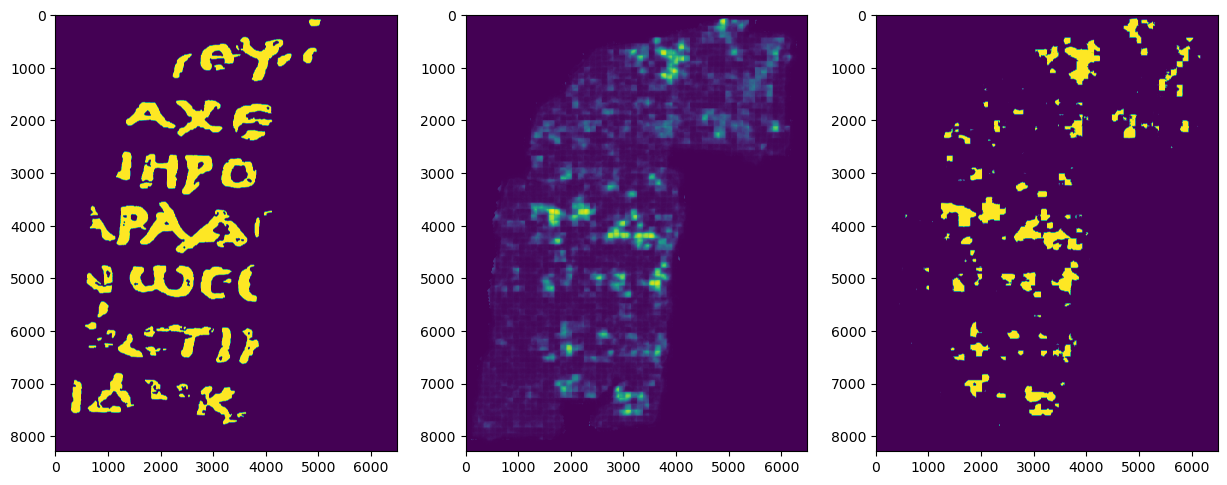

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([3.9958932e+07, 6.0164990e+06, 2.4355010e+06, 1.5193540e+06,
        1.0329200e+06, 6.9186000e+05, 5.1508600e+05, 3.5544800e+05,
        2.5200300e+05, 1.8306600e+05, 1.5625100e+05, 1.4230600e+05,
        1.3262700e+05, 1.0726900e+05, 9.4393000e+04, 8.6592000e+04,
        7.0022000e+04, 5.3753000e+04, 2.9140000e+04, 5.8260000e+03]),
 array([1.55281637e-06, 4.64167811e-02, 9.28320093e-02, 1.39247238e-01,
        1.85662466e-01, 2.32077694e-01, 2.78492922e-01, 3.24908151e-01,
        3.71323379e-01, 4.17738607e-01, 4.64153835e-01, 5.10569063e-01,
        5.56984292e-01, 6.03399520e-01, 6.49814748e-01, 6.96229976e-01,
        7.42645205e-01, 7.89060433e-01, 8.35475661e-01, 8.81890889e-01,
        9.28306118e-01]),
 <BarContainer object of 20 artists>)

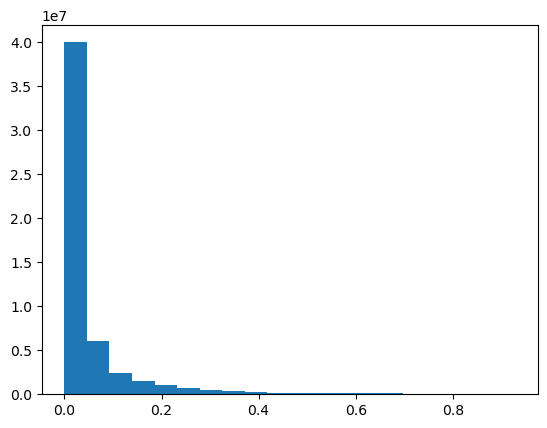

In [39]:
plt.hist(mask_pred.flatten(), bins=20)

In [40]:
# GPU VRAM 5.2GB/16.0GB A4000